In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, layers
import tensorflow.keras as keras
import glob
from PIL import Image, ImageFilter

import io


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
filenames = glob.glob('../data/train/*/*')

In [4]:
TRAIN_LENGTH = 2500
VAL_LENGTH = 500
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (3000, 128, 128, 3)

In [5]:
import random
random.shuffle(filenames)

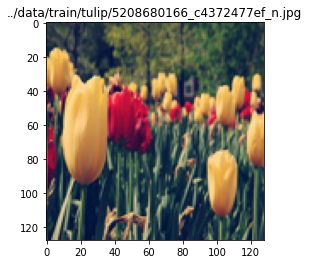

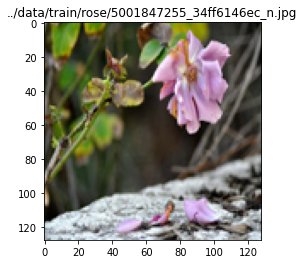

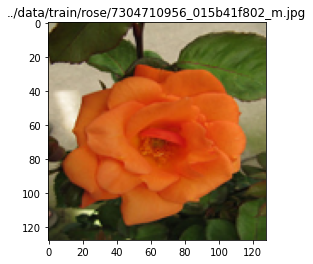

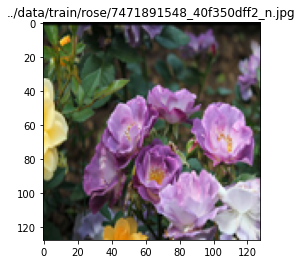

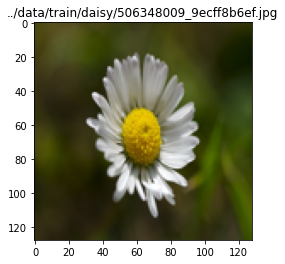

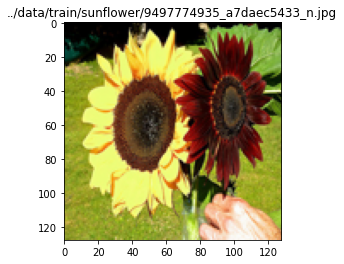

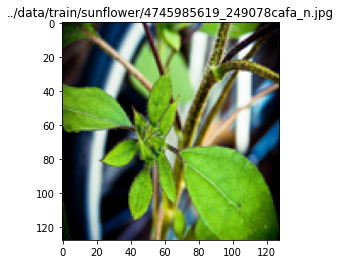

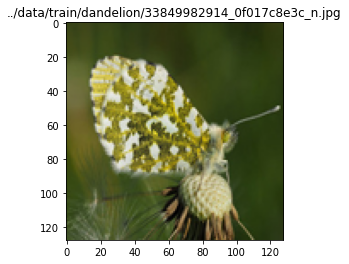

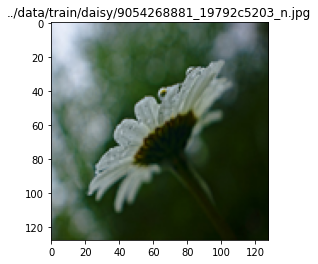

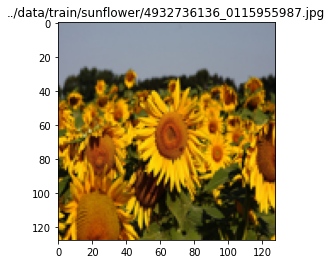

In [6]:
for i in range(10):
    x = Image.open(filenames[i])
    x = x.resize(IMAGE_SIZE)
    plt.imshow(x)
    plt.title(filenames[i])
    plt.show()

# Layers


In [7]:
class FeatureEncoder(layers.Layer):
    def __init__(self, out_channels, kernel_size):
        super(FeatureEncoder, self).__init__()
        self.conv = keras.Sequential([
                layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding='same', activation='relu'),
                layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding='same', activation='relu'),
                layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding='same', activation='relu')
                ])
        
        self.fe_down = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, strides=2, padding='same',
                                            activation='relu')
        
    def call(self, x):
        x = self.conv(x)
        f = x
        x = self.fe_down(x)
        return f, x
    
class FeatureDecoder(layers.Layer):
    def __init__(self, out_channels, kernel_size):
        super(FeatureDecoder, self).__init__()
        self.de_up = layers.Conv2DTranspose(filters=out_channels, kernel_size=kernel_size, strides=2, 
                                             padding='same', output_padding=1)
        
        self.conv_first = layers.Conv2D(filters=out_channels, kernel_size=1, padding='same', activation='relu')
        self.conv = keras.Sequential([
                layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding='same', activation='relu'),
                layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding='same', activation='relu'),
                layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding='same', activation='relu')
            ])
        self.conv_last = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding='same')

    def call(self, x, down_tensor):
        x = self.de_up(x)
        
        # Calculate cropping for down_tensor to concatenate with x
        _, h2, w2, _ = down_tensor.shape
        _, h1, w1, _ = x.shape
        h_diff, w_diff = h2 - h1, w2 - w1
        
        cropping = ((int(np.ceil(h_diff / 2)), int(np.floor(h_diff / 2))),
                    (int(np.ceil(w_diff / 2)), int(np.floor(w_diff / 2))))
        down_tensor = layers.Cropping2D(cropping=cropping)(down_tensor)        
        x = layers.concatenate([x, down_tensor], axis=3)
        
        x = self.conv_first(x)
        x = self.conv(x)
        x = self.conv_last(x)
        return x

# Model

In [8]:
class DPDNN(Model):
    def __init__(self):
        super(DPDNN, self).__init__()
        self.fe1 = FeatureEncoder(out_channels=64, kernel_size=3)
        self.fe2 = FeatureEncoder(out_channels=64, kernel_size=3)
        self.fe3 = FeatureEncoder(out_channels=64, kernel_size=3)
        self.fe4 = FeatureEncoder(out_channels=64, kernel_size=3)
        self.fe_end = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
        
        self.de4 = FeatureDecoder(out_channels=64, kernel_size=3)
        self.de3 = FeatureDecoder(out_channels=64, kernel_size=3)
        self.de2 = FeatureDecoder(out_channels=64, kernel_size=3)
        self.de1 = FeatureDecoder(out_channels=64, kernel_size=3)
        self.de_end = layers.Conv2D(filters=1, kernel_size=3, padding='same')
        
        # Defining learnable parameters
        self.delta_1 = tf.Variable(0.1, trainable=True)
        self.eta_1 = tf.Variable(0.9, trainable=True)
        
        self.delta_2 = tf.Variable(0.1, trainable=True)
        self.eta_2 = tf.Variable(0.9, trainable=True)
        
        self.delta_3 = tf.Variable(0.1, trainable=True)
        self.eta_3 = tf.Variable(0.9, trainable=True)
        
        self.delta_4 = tf.Variable(0.1, trainable=True)
        self.eta_4 = tf.Variable(0.9, trainable=True)
        
        self.delta_5 = tf.Variable(0.1, trainable=True)
        self.eta_5 = tf.Variable(0.9, trainable=True)
        
        self.delta_6 = tf.Variable(0.1, trainable=True)
        self.eta_6 = tf.Variable(0.9, trainable=True)

    
    def call(self, x):
        y = x
        
        for i in range(6):
            f1, out = self.fe1(x)
            f2, out = self.fe2(out)
            f3, out = self.fe3(out)
            f4, out = self.fe4(out)
            out = self.fe_end(out)

            out = self.de4(out, f4)
            out = self.de3(out, f3)
            out = self.de2(out, f2)
            out = self.de1(out, f1)
            v = self.de_end(out)

            v = v + x
            x = self.reconnect(v, x, y, i)
            
        return x
    
    def reconnect(self, v, x, y, i):
        i = i + 1
        if i == 1:
            delta = self.delta_1
            eta = self.eta_1
        if i == 2:
            delta = self.delta_2
            eta = self.eta_2
        if i == 3:
            delta = self.delta_3
            eta = self.eta_3
        if i == 4:
            delta = self.delta_4
            eta = self.eta_4
        if i == 5:
            delta = self.delta_5
            eta = self.eta_5
        if i == 6:
            delta = self.delta_6
            eta = self.eta_6
        
        recon = tf.multiply((1 - delta - eta), v) + tf.multiply(eta, x) + tf.multiply(delta, y)
        return recon

# Dataset

In [9]:
def _generate_pair(filename):
    im = Image.open(filename)
    im = im.resize(IMAGE_SIZE)
    y = np.array(im)
    y_min, y_max = np.min(y), np.max(y)
    y_normalized = (y - y_min) / (y_max - y_min)

    blur_radius = np.random.uniform(1, 5)
    blurred_im = im.filter(ImageFilter.GaussianBlur(blur_radius))
    x = np.array(blurred_im)
    x_min, x_max = np.min(x), np.max(x)
    x_normalized = (x - x_min) / (x_max - x_min)
    
    return (x_normalized, y_normalized)
    

In [10]:
def create_datasets(filenames):
    random.shuffle(filenames)
    dataset = list(map(_generate_pair, filenames))
    x_train, y_train = zip(*dataset)
    return np.array(x_train), np.array(y_train)
    

In [11]:
x_train, y_train = create_datasets(filenames)

# Logging

In [12]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def plot_image_tensorboard(epoch, logs):
    # Create a plot to visualize image reconstruction progress

    # Call the model to get prediction
    pred = model.predict(val_sample[0][0][np.newaxis])

    # Create a mpl figure
    figure = plt.figure(figsize=(10,10))

    # Plot the prediction
    plt.subplot(1, 2, 1)
    plt.title("prediction")
    plt.imshow(pred[0].astype(np.float32))
    # Plot groundtruth
    plt.subplot(1, 2, 2)
    plt.title("ground truth")
    plt.imshow(val_sample[1][0].numpy().astype(np.float32))
    plot_image = plot_to_image(figure)
    with file_writer.as_default():
        tf.summary.image("Prediction vs Ground Truth", plot_image, step=epoch)

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def plot_image_tensorboard(epoch, logs):
    # Create a plot to visualize image reconstruction progress
    
    # Call the model to get prediction
    pred = model.predict(val_sample[0][np.newaxis, ...])

    # Create a mpl figure
    figure = plt.figure(figsize=(10,10))

    # Plot the prediction
    plt.subplot(1, 2, 1)
    plt.title("prediction")
    plt.imshow(pred[0].astype(np.float32))
    # Plot groundtruth
    plt.subplot(1, 2, 2)
    plt.title("ground truth")
    plt.imshow(val_sample[1].astype(np.float32))
    plot_image = plot_to_image(figure)
    with file_writer.as_default():
        tf.summary.image("Prediction vs Ground Truth", plot_image, step=epoch)

import datetime
log_dir=os.path.join('logs', 'fit') + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=1000000)
file_writer = tf.summary.create_file_writer(log_dir)

plot_image_tensorboard_cb = keras.callbacks.LambdaCallback(on_epoch_end=plot_image_tensorboard)

# Training

In [13]:
model = DPDNN()

In [14]:
EPOCHS = 100
BATCH_SIZE = 8
STEPS_PER_EPOCH = 3000 // BATCH_SIZE
VAL_STEPS = VAL_LENGTH // BATCH_SIZE

In [15]:
adam = tf.keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
model.build(INPUT_SHAPE)
model.summary()

Model: "dpdnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_encoder (FeatureEnco multiple                  112576    
_________________________________________________________________
feature_encoder_1 (FeatureEn multiple                  147712    
_________________________________________________________________
feature_encoder_2 (FeatureEn multiple                  147712    
_________________________________________________________________
feature_encoder_3 (FeatureEn multiple                  147712    
_________________________________________________________________
conv2d_16 (Conv2D)           multiple                  36928     
_________________________________________________________________
feature_decoder (FeatureDeco multiple                  192896    
_________________________________________________________________
feature_decoder_1 (FeatureDe multiple                  192896

In [16]:
val_sample = (x_train[0], y_train[0])

In [ ]:
model.fit(x_train, y_train, epochs=400, batch_size=8, validation_split=0.1, 
          callbacks=[plot_image_tensorboard_cb, tensorboard_callback])

Epoch 1/400

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

338/338 [==============================] - ETA: 0s - loss: 0.0113 - mean_squared_error: 0.0113

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 109s 321ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 2/400
338/338 [==============================] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 106s 313ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 3/400
338/338 [==============================] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 315ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 4/400
338/338 [==============================] - ETA: 0s - loss: 0.0087 - mean_squared_error: 0.0087

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 316ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 5/400
338/338 [==============================] - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.0085

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 316ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 6/400
338/338 [==============================] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 316ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 7/400
338/338 [==============================] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 8/400
338/338 [==============================] - ETA: 0s - loss: 0.0083 - mean_squared_error: 0.0083

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 9/400
338/338 [==============================] - ETA: 0s - loss: 0.0083 - mean_squared_error: 0.0083

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 10/400
338/338 [==============================] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 11/400
338/338 [==============================] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 12/400
338/338 [==============================] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 13/400
338/338 [==============================] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 14/400
338/338 [==============================] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 15/400
338/338 [==============================] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 316ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 16/400
338/338 [==============================] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 17/400
338/338 [==============================] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 18/400
338/338 [==============================] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 316ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 19/400
338/338 [==============================] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 20/400
338/338 [==============================] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 21/400
338/338 [==============================] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 22/400
338/338 [==============================] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 23/400
338/338 [==============================] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 24/400
338/338 [==============================] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 25/400
338/338 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 26/400
338/338 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 27/400
338/338 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 28/400
338/338 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 29/400
338/338 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 30/400
338/338 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 31/400
338/338 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 32/400
338/338 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 33/400
338/338 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 34/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 35/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 36/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 37/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 38/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 39/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 40/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 41/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 42/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 43/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 44/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 45/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 46/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 47/400
338/338 [==============================] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 48/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 49/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 50/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 51/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 52/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 53/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 54/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 55/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 56/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 57/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 58/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 59/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 60/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 61/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 62/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 63/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 64/400
338/338 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 65/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 66/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 67/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 68/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 69/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 70/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 71/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 72/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 73/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 74/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 75/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 108s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 76/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 77/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 78/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 79/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 80/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 81/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 82/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 83/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 84/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 85/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 86/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 87/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 88/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 89/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 108s 318ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 90/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 91/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 92/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 93/400
338/338 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 94/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 318ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 95/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 96/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 97/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 108s 318ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 98/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 108s 318ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 99/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 108s 318ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 100/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 101/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 102/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 103/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 104/400
338/338 [==============================] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 105/400
338/338 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


338/338 [==============================] - 107s 317ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 106/400
238/338 [====================>.........] - ETA: 30s - loss: 0.0074 - mean_squared_error: 0.0074

In [ ]:
i = 3
a = model.predict(x_train[np.newaxis, i, ...])

In [ ]:
plt.imshow(y_train[i])

In [ ]:
plt.imshow(x_train[i])

In [ ]:
plt.imshow(np.squeeze(a))